In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,FunctionTransformer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay
from scipy.interpolate import CubicSpline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc


## Logistic Regression

**Logistic Regression** is a statistical technique used for **binary classification**, which predicts the probability that an input belongs to a specific class.

### Objective

Given a feature vector $X = [x_1, x_2, \dots, x_p]$, logistic regression estimates the probability that the outcome $y$ is the positive class ($y = 1$) as:

$$
P(y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_p x_p)}}
$$

Here,  
- $\beta_0$ is the **intercept** term,  
- $\beta_i$ are the **coefficients** corresponding to each feature $x_i$.
---
### Logit Function

The model transforms this probability using the **logit function**:

$$
\text{logit}(P) = \log\left(\frac{P}{1 - P}\right) = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p
$$

This transformation converts the bounded probability $P \in (0,1)$ into an unbounded linear scale.

---

### Loss Function

Logistic regression parameters are estimated via **maximum likelihood estimation (MLE)**. The log-likelihood for $n$ data points is:

$$
\mathcal{L}(\beta) = \sum_{i=1}^n \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

where $p_i = P(y_i=1 \mid X_i)$ is the predicted probability for the $i$-th observation.

Minimizing the negative of this log-likelihood is equivalent to minimizing the **binary cross-entropy loss**.

---

### Decision Boundary

A typical classification threshold is set at $0.5$:

- Predict class 1 if $P(y=1 \mid X) \geq 0.5$,  
- Otherwise, predict class 0.

This threshold can be adjusted to balance metrics such as **precision** and **recall** depending on the problem context.
---

### Assumptions

- The logit (log-odds) is a linear function of the predictors,  
- Observations are independent,  
- There is little to no multicollinearity among predictors,  
- Sample size is sufficiently large for reliable parameter estimates.
---

### Interpretation of Coefficients

Each coefficient $\beta_j$ corresponds to the change in **log-odds** of the positive outcome for a one-unit increase in feature $x_j$, holding all other variables constant.

- A positive $\beta_j$ increases the log-odds of $y=1$,  
- A negative $\beta_j$ decreases the log-odds,  
- Exponentiating $\beta_j$ gives the **odds ratio**:

$$
\text{Odds Ratio} = e^{\beta_j}
$$

which quantifies how the odds change with a one-unit increase in $x_j$.

---
### Summary

Logistic regression is:  
- Interpretable,  
- Computationally efficient,  
- A reliable baseline model for binary classification problems.

It works best when the relationship between predictors and the log-odds of the outcome is linear.

--- 

## SMOTE: Synthetic Minority Over-sampling Technique

**SMOTE** is a data augmentation method designed to address class imbalance in classification tasks. It works by generating **synthetic examples** for the **minority class** using a linear interpolation between existing samples.

---

### Motivation

In binary classification, imbalanced datasets can bias the model toward the majority class. For example, if only 5% of patients in a dataset have a stroke (`y=1`), a classifier can achieve 95% accuracy by always predicting `y=0`.

This leads to poor performance on the minority class (e.g., low recall for stroke prediction). **SMOTE** remedies this by **generating new synthetic samples** from the minority class in a way that preserves the feature space geometry.

---

### Mathematical Explanation

Let:

- $x_i \in \mathbb{R}^n$ be a feature vector from the **minority class**  
- $\mathcal{N}_k(x_i)$ denote the set of its **k-nearest neighbors** in the minority class  
- $x_{zi} \in \mathcal{N}_k(x_i)$ be one of those neighbors (selected randomly)

The **synthetic point** $\tilde{x}$ is generated as:

$$
\tilde{x} = x_i + \lambda \cdot (x_{zi} - x_i)
$$

Where:

- $\lambda \sim \mathcal{U}(0, 1)$ is a random scalar drawn from a **uniform distribution**  
- The term $(x_{zi} - x_i)$ is the vector from $x_i$ to one of its neighbors  
- This produces new samples **along the line segment** between $x_i$ and $x_{zi}$

---

### SMOTE in Practice

1. For each minority instance $x_i$, pick $k$-nearest neighbors $\mathcal{N}_k(x_i)$  
2. For each synthetic sample to generate:
   - Randomly select $x_{zi} \in \mathcal{N}_k(x_i)$  
   - Sample $\lambda \in [0, 1]$  
   - Compute:

   $$
   \tilde{x} = x_i + \lambda \cdot (x_{zi} - x_i)
   $$

3. Add $\tilde{x}$ to the training set with label $y = 1$

This creates **synthetic minority class points** that **expand the decision region**, helping models learn better **generalization boundaries**.




## Data Exploration

In [36]:
data = pd.read_csv("C:\\Users\\Sebastian\\Documents\\Datasets\\healthcare-dataset-stroke-data.csv")
# Display the first few rows of the dataset


data.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [37]:
cleaned_data = data.copy()


In [38]:
data_dropped = cleaned_data.dropna()

data_dropped

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [39]:
len(data_dropped) / len(data)

0.960665362035225

- There was a 3.84 % data loss after dropping Na values. 

# **Interpolation**

For this Project I would like to take the time to use the spline method for interpolation. Since the data loss was rather small, I believe that interpolating and imputing generated data will help the models accuracy.

This project also emphasizes the Use of SMOTE; which on its own is a way to generate synthetic data in order to cover imbalanced datasets.

---

## **Mathematical Theory**

### Cubic Spline Interpolation

Cubic spline interpolation uses piecewise cubic polynomials to create a smooth curve through a set of points. For $n$ points, we create $n-1$ cubic polynomials, one for each interval between points.

Given points $(x_i, y_i)$ for $i = 1, 2, ..., n$, we define a cubic polynomial for each interval $[x_i, x_{i+1}]$:

$S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3$

where $i = 1, 2, ..., n-1$

The coefficients $a_i, b_i, c_i,$ and $d_i$ are determined by enforcing the following conditions:

1. The spline passes through all points: $S_i(x_i) = y_i$ and $S_i(x_{i+1}) = y_{i+1}$
2. The first derivatives are continuous at interior points: $S'_i(x_{i+1}) = S'_{i+1}(x_{i+1})$
3. The second derivatives are continuous at interior points: $S''_i(x_{i+1}) = S''_{i+1}(x_{i+1})$
4. The second derivative is zero at the endpoints (natural spline condition): $S''_1(x_1) = S''_{n-1}(x_n) = 0$

These conditions lead to a system of linear equations that can be solved to find all coefficients.

For any $x^*$ in the interval $[x_i, x_{i+1}]$, we can find $y^*$ using:

$y^* = S_i(x^*) = a_i + b_i(x^* - x_i) + c_i(x^* - x_i)^2 + d_i(x^* - x_i)^3$

The resulting spline is continuous up to the second derivative, ensuring a smooth curve through all given points.


In [40]:
cleaned_data = cleaned_data.infer_objects(copy=False)
data_interpolated = cleaned_data.interpolate(method='spline', order=3)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_26964\2084737408.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_interpolated = cleaned_data.interpolate(method='spline', order=3)


In [41]:
# Check if any NaNs remain
data_interpolated.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [42]:
# Number of NaNs before
print("Before interpolation:")
print(cleaned_data.isna().sum())

# Number of NaNs after
print("\nAfter interpolation:")
print(data_interpolated.isna().sum())

Before interpolation:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

After interpolation:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


### **Checking the Interpolation assumptions:**

In [43]:
col = 'bmi'
series = data_interpolated[col]

# Get known (non-NaN) x and y
known_x = series.dropna().index.to_numpy()
known_y = series.dropna().values

# Fit natural cubic spline
spline = CubicSpline(known_x, known_y, bc_type='natural')

# 1. Passes through all known points
assert np.allclose(spline(known_x), known_y), "Fails interpolation condition"

# 2. First derivative continuity
dx = 1e-5
first_deriv_jump = [
    abs(spline(x + dx, 1) - spline(x - dx, 1)) for x in known_x[1:-1]
]
print("Max jump in first derivative:", max(first_deriv_jump))

# 3. Second derivative continuity
second_deriv_jump = [
    abs(spline(x + dx, 2) - spline(x - dx, 2)) for x in known_x[1:-1]
]
print("Max jump in second derivative:", max(second_deriv_jump))

# 4. Natural spline condition (2nd derivative zero at endpoints)
print("2nd derivative at first point:", spline(known_x[0], 2))
print("2nd derivative at last point:", spline(known_x[-1], 2))

Max jump in first derivative: 0.005953627538460182
Max jump in second derivative: 0.002765435228909041
2nd derivative at first point: 0.0
2nd derivative at last point: 0.0


- The assumptions for the cublic splines are successfully met.

## **Exploratory Data Analysis**

In [44]:
variables = [variable for variable in data_interpolated if variable not in ['id','stroke']]

cont_var = ['age','avg_glucose_level','bmi']


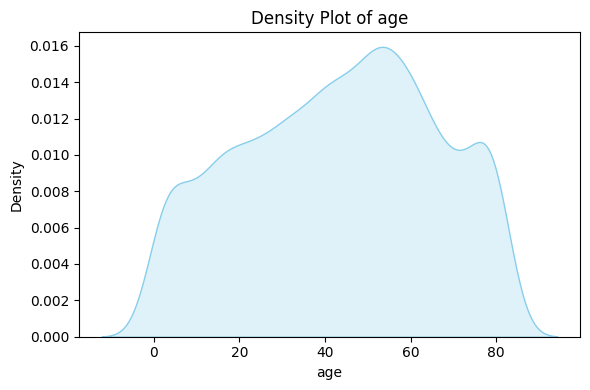

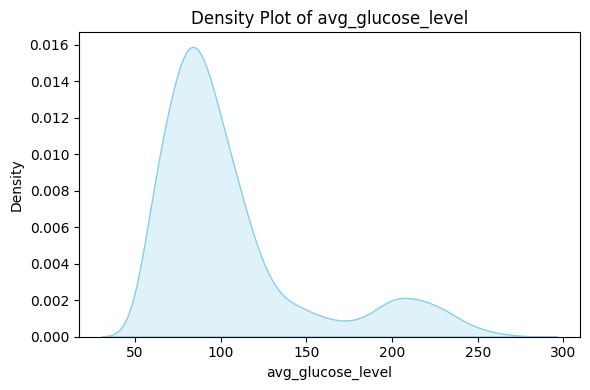

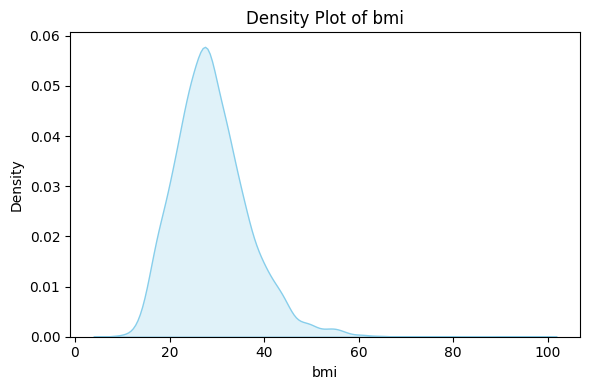

In [45]:
for col in cont_var:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data_interpolated[col].dropna(), fill=True, color='skyblue')
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

- Looking at the denisity plots for the continuous variables there are multiple instances of skewness, and one of multimodality.
- The patients affected seem to be around the age of 45, with a bmi of 30, and the vast majority with an avg glucose level of 90.
- The multimodality of the avg glucose sample suggests a moderate number of people with extremely high levels; this could suggest comorbidities like diabetes or obesity.

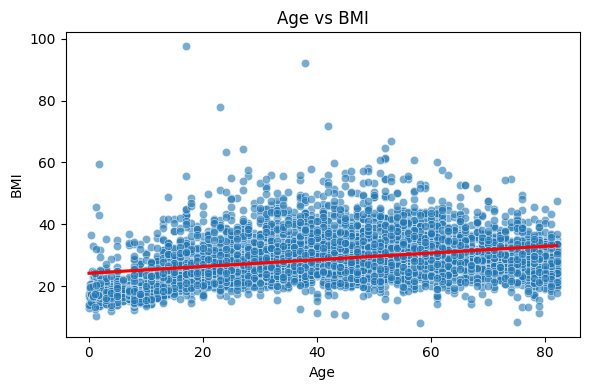

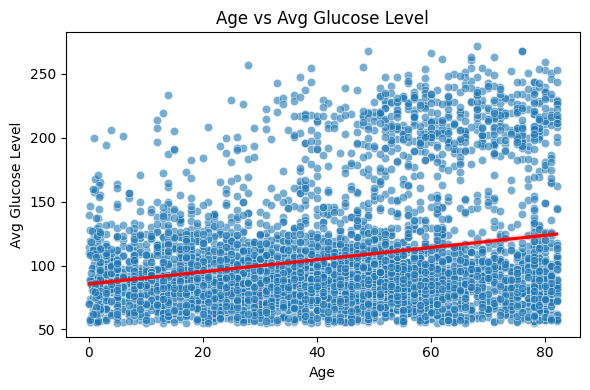

In [46]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='age', y='bmi', data=data_interpolated, alpha=0.6)
sns.regplot(x='age', y='bmi', data=data_interpolated, scatter=False, color='red')
plt.title('Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='age', y='avg_glucose_level', data=data_interpolated, alpha=0.6)
sns.regplot(x='age', y='avg_glucose_level', data=data_interpolated, scatter=False, color='red')
plt.title('Age vs Avg Glucose Level')
plt.xlabel('Age')
plt.ylabel('Avg Glucose Level')
plt.tight_layout()
plt.show()

- The relationship between age and the corresponding continuous variables is linear and positive.

## Outlier Detection

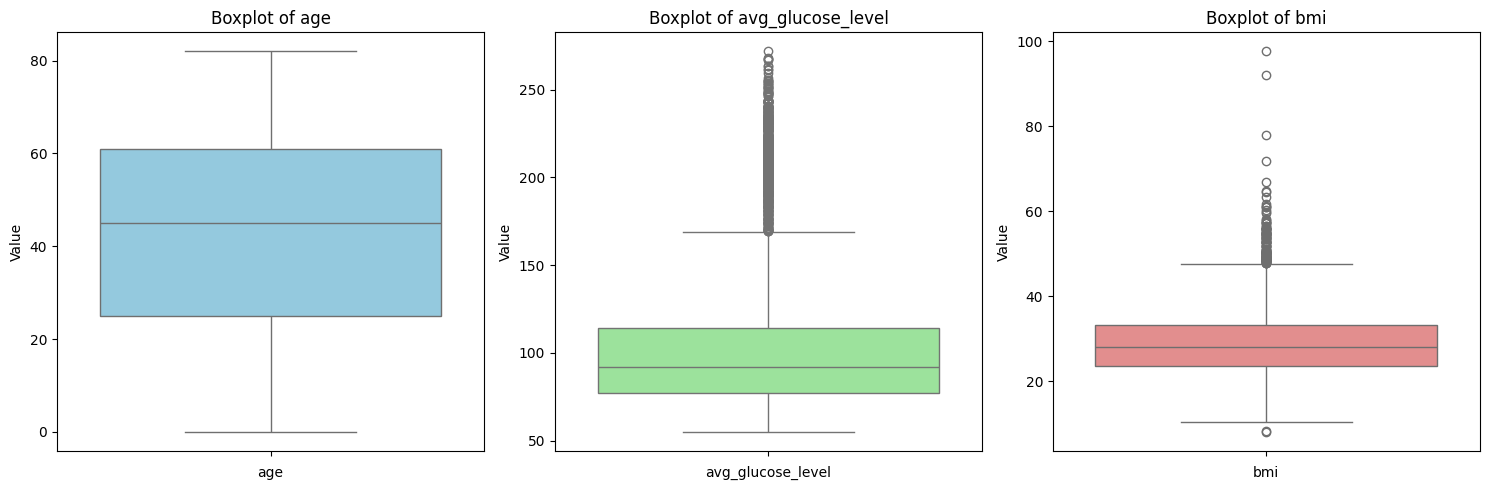

In [47]:
true_numeric_features = ['age', 'avg_glucose_level', 'bmi']
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(15, 5))

for i, (col, color) in enumerate(zip(true_numeric_features, colors), 1):
    plt.subplot(1, len(true_numeric_features), i)
    sns.boxplot(y=data_interpolated[col], color=color)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Value')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [48]:
# 1. Get true numeric columns BEFORE one-hot encoding
true_numeric_features = ['age', 'avg_glucose_level', 'bmi']  # You can add others you know are continuous

# 2. Concatenate with target to preserve rows
data_no_outliers = data_interpolated.copy()

# 3. IQR filtering for each numeric column
for col in true_numeric_features:
    Q1 = data_no_outliers[col].quantile(0.25)
    Q3 = data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = data_no_outliers[
        (data_no_outliers[col] >= lower_bound) & (data_no_outliers[col] <= upper_bound)
    ]

# 4. Check how many rows were removed
print(f"Original shape: {data_interpolated.shape}")
print(f"After outlier removal: {data_no_outliers.shape}")

Original shape: (5110, 12)
After outlier removal: (4389, 12)


In [49]:
original_count = data_interpolated.shape[0]
filtered_count = data_no_outliers.shape[0]

data_lost = original_count - filtered_count
percent_lost = (data_lost / original_count) * 100

print(f"Original rows: {original_count}")
print(f"Rows after outlier removal: {filtered_count}")
print(f"Rows removed: {data_lost}")
print(f"Percentage of data lost: {percent_lost:.2f}%")

Original rows: 5110
Rows after outlier removal: 4389
Rows removed: 721
Percentage of data lost: 14.11%


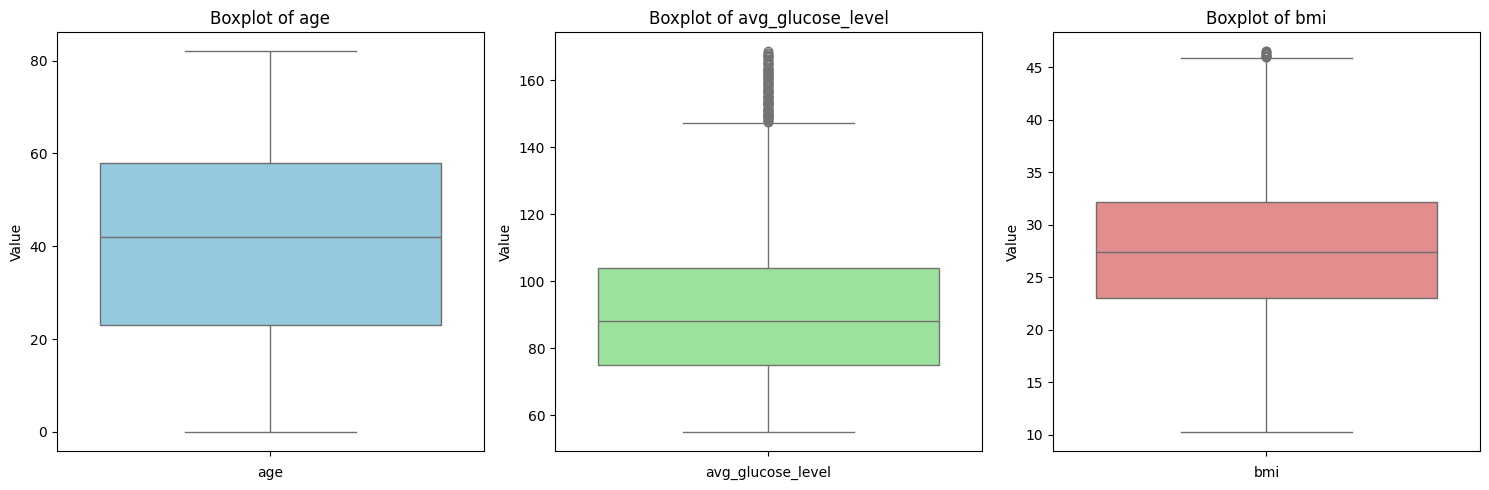

In [50]:
true_numeric_features = ['age', 'avg_glucose_level', 'bmi']
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(15, 5))

for i, (col, color) in enumerate(zip(true_numeric_features, colors), 1):
    plt.subplot(1, len(true_numeric_features), i)
    sns.boxplot(y=data_no_outliers[col], color=color)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Value')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


- Even though the Outliers are an important group of people; their data will throw the models estimates off.
- A suggested approach is to separate the outliers into a new dataset which can also have an attribute to indicate Obesity as a [0,1].
- I personally believe that they would need an analysis of their own.

## Data Transformation

- Although it seems like work_type is important to gauge stress levels, I would like to remove it. This is because I would like to keep the model parsimonous to avoid overfitting.

In [51]:
# Separate features and target variable in the cleaned dataset
X_cleaned = data_no_outliers.drop(columns=['stroke','id','work_type'])
y_cleaned = data_no_outliers['stroke']
# Split the cleaned dataset into train and test sets
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned,
y_cleaned, test_size=0.3, random_state=42)
# Define preprocessing steps for numeric and categorical features
numeric_features = X_cleaned.select_dtypes(include=['int64', 'float64']).columns

categorical_features = X_cleaned.select_dtypes(include=['object']).columns

print(f"{numeric_features}\n\n{categorical_features}")

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')

Index(['gender', 'ever_married', 'Residence_type', 'smoking_status'], dtype='object')


Continuous numeric features for log-odds plots: ['age', 'avg_glucose_level', 'bmi']


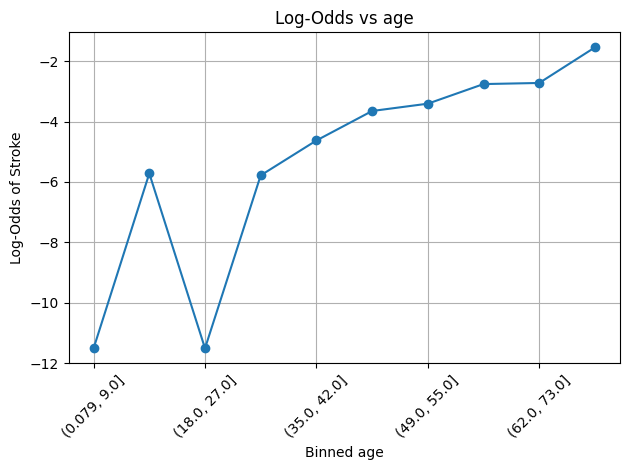

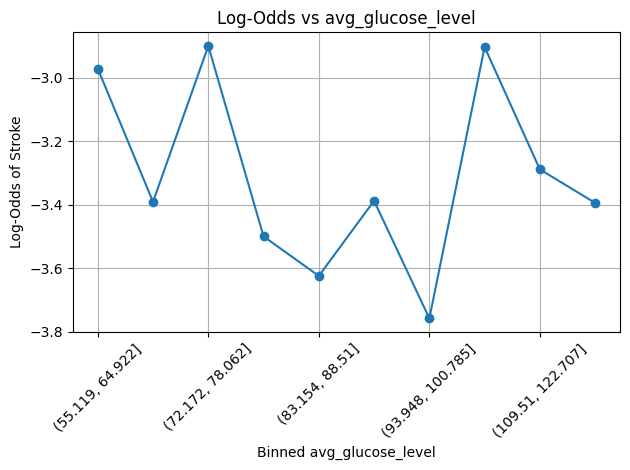

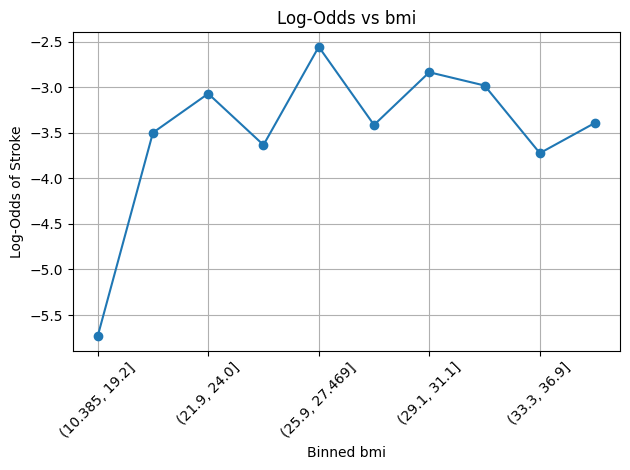

In [52]:
# Checking the Assumptions for the Logistic Regression Model
# ===============================
# LINEARITY OF THE LOGIT (Log-Odds)
# ===============================

numeric_features = X_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Filter out columns with few unique values (likely categorical/binary)
continuous_numeric_features = [col for col in numeric_features if X_train_cleaned[col].nunique() > 5]

print("Continuous numeric features for log-odds plots:", continuous_numeric_features)

X_train_temp = X_train_cleaned.copy()
X_train_temp['stroke'] = y_train_cleaned

epsilon = 1e-5  # small value to avoid log(0)

for col in continuous_numeric_features:
    X_train_temp['bin'] = pd.qcut(X_train_temp[col], q=10, duplicates='drop')
    # Explicitly set observed=False to avoid FutureWarning
    grouped = X_train_temp.groupby('bin', observed=False)['stroke'].mean()
    
    # Clip probabilities to avoid log(0) issues
    probs = grouped.clip(epsilon, 1 - epsilon)
    log_odds = np.log(probs / (1 - probs))
    
    plt.figure()
    log_odds.plot(marker='o')
    plt.title(f'Log-Odds vs {col}')
    plt.xlabel(f'Binned {col}')
    plt.ylabel('Log-Odds of Stroke')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [53]:
# Define which numeric features are for each transformation
other_numeric_features = [col for col in numeric_features if col not in ['bmi', 'avg_glucose_level']]

# Create a copy for transformation
X_train_transformed = pd.DataFrame()

# Standard scale other numeric features
scaler = StandardScaler()
X_train_transformed[other_numeric_features] = scaler.fit_transform(X_train_cleaned[other_numeric_features])

# Log-transform and scale bmi
X_train_transformed['bmi'] = scaler.fit_transform(np.log1p(X_train_cleaned[['bmi']]))

# Polynomial (degree 2) transform and scale avg_glucose_level
poly = PolynomialFeatures(degree=2, include_bias=False)
glucose_poly = poly.fit_transform(X_train_cleaned[['avg_glucose_level']])
glucose_poly_scaled = scaler.fit_transform(glucose_poly)
X_train_transformed['avg_glucose_level'] = glucose_poly_scaled[:, 0]
X_train_transformed['avg_glucose_level_squared'] = glucose_poly_scaled[:, 1]

# Add target for plotting
X_train_transformed['stroke'] = y_train_cleaned.reset_index(drop=True)

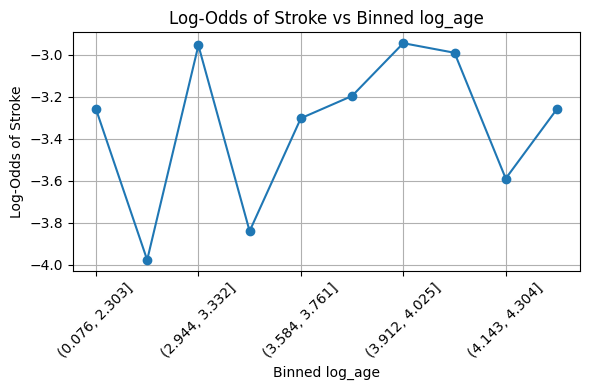

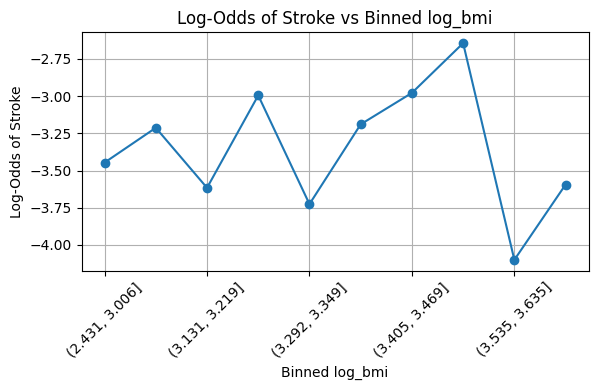

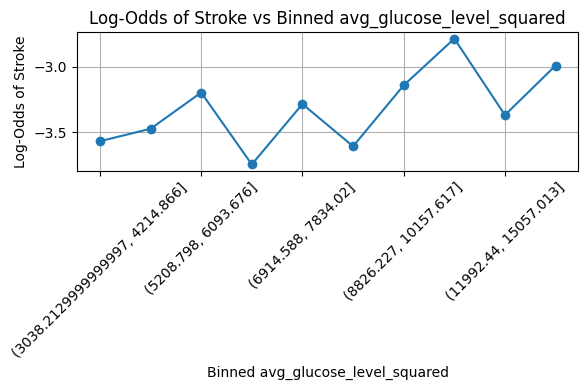

In [54]:
# Copy data and add target
X_train_temp = X_train_cleaned.copy()
X_train_temp['stroke'] = y_train_cleaned.reset_index(drop=True)

# Create transformed variables
X_train_temp['log_age'] = np.log1p(X_train_temp['age'])
X_train_temp['log_bmi'] = np.log1p(X_train_temp['bmi'])
X_train_temp['avg_glucose_level_squared'] = X_train_temp['avg_glucose_level'] ** 2

# Features to plot: all transformed now
features_to_plot = ['log_age', 'log_bmi', 'avg_glucose_level_squared']

eps = 1e-5  # epsilon to avoid division by zero

for col in features_to_plot:
    # Bin feature into 10 quantiles (deciles)
    X_train_temp['bin'] = pd.qcut(X_train_temp[col], q=10, duplicates='drop')
    
    # Calculate mean stroke probability per bin with observed=False to fix warning
    grouped = X_train_temp.groupby('bin', observed=False)['stroke'].mean()
    
    # Calculate log-odds (add epsilon to avoid divide-by-zero)
    probs = grouped.clip(eps, 1 - eps)
    log_odds = np.log(probs / (1 - probs))
    
    # Plot
    plt.figure(figsize=(6,4))
    log_odds.plot(marker='o')
    plt.title(f'Log-Odds of Stroke vs Binned {col}')
    plt.xlabel(f'Binned {col}')
    plt.ylabel('Log-Odds of Stroke')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [55]:

# ===============================
# 4. INDEPENDENT OBSERVATIONS
# ===============================
print("Assuming independence since data seems to be individual patient records; they do not seem to be repeated measurements.\n")

# ===============================
# 5. BINARY OUTCOME
# ===============================
print(f"\nTarget classes: {y_cleaned.unique()}")
print(f"Class balance:\n{y_cleaned.value_counts(normalize=True)}\n")

Assuming independence since data seems to be individual patient records; they do not seem to be repeated measurements.


Target classes: [1 0]
Class balance:
stroke
0    0.962634
1    0.037366
Name: proportion, dtype: float64



## Multicollinearity Check

## VIF write up

## Variance Inflation Factor (VIF)

Variance Inflation Factor (VIF) is a diagnostic tool used to detect **multicollinearity** in regression models. It quantifies how much the variance of a regression coefficient is inflated due to linear dependence with other predictors.

### Mathematical Definition

For a given predictor variable $X_j$, the VIF is defined as:

$$
\text{VIF}(X_j) = \frac{1}{1 - R_j^2}
$$

Where:
- $R_j^2$ is the coefficient of determination when $X_j$ is regressed on all the other predictor variables.

### Interpretation

- $\text{VIF} = 1$: No multicollinearity  
- $1 < \text{VIF} < 5$: Moderate multicollinearity  
- $\text{VIF} > 5$: High multicollinearity; investigate further  
- $\text{VIF} > 10$: Serious multicollinearity; consider removing the variable

High VIF values can **destabilize regression coefficients**, making them unreliable.


In [56]:
# ===============================
# MULTICOLLINEARITY (VIF)
# ===============================
# We only assess numeric features here.
X_numeric = X_train_cleaned[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print("\nVariance Inflation Factor (VIF) for Numeric Features:")
print(vif_data.sort_values(by='VIF', ascending=False))



Variance Inflation Factor (VIF) for Numeric Features:
             feature       VIF
0                age  1.285996
4                bmi  1.153795
1       hypertension  1.074978
2      heart_disease  1.068002
3  avg_glucose_level  1.001764


- The resulting VIF values show no multicollinearity, the usual threshold is 5.0 none of the variables crossed it.

In [57]:
num_events = y_train_cleaned.sum()
print(f"Number of stroke events in training data: {num_events}")

Number of stroke events in training data: 112


## Checking Sample Size Assumption

In [58]:
num_numeric = len(numeric_features)

# For categorical, count unique values for each categorical column (these will become one-hot)
num_categorical_expanded = sum(X_train_cleaned[col].nunique() for col in categorical_features)

# If you have polynomial features (like squared glucose), add extra columns manually:
# For example, glucose_quad = 2 features (original + squared)
# So replace glucose feature count with 2 features

if 'avg_glucose_level' in numeric_features:
    # Subtract 1 (original glucose) and add 2 (poly features)
    num_numeric_adjusted = num_numeric - 1 + 2
else:
    num_numeric_adjusted = num_numeric

# Similarly, if you log-transform BMI (still 1 feature)
# So just keep BMI count as is

# Total predictors estimated:
total_predictors = num_numeric_adjusted + num_categorical_expanded

print(f"Estimated total number of predictors (before fitting): {total_predictors}")

# 2. Calculate least frequent outcome proportion
outcome_counts = y_train_cleaned.value_counts(normalize=True)
least_freq_outcome_proportion = outcome_counts.min()
print(f"Proportion of least frequent outcome: {least_freq_outcome_proportion:.4f}")

# 3. Calculate minimum sample size recommended
min_sample_size = (10 * total_predictors) / least_freq_outcome_proportion
print(f"Minimum recommended sample size: {min_sample_size:.0f}")

# 4. Actual sample size
actual_sample_size = len(X_train_cleaned)
print(f"Actual sample size: {actual_sample_size}")

# 5. Check sufficiency
if actual_sample_size >= min_sample_size:
    print("Sample size is sufficient for logistic regression.")
else:
    print("Sample size is NOT sufficient for logistic regression.")

Estimated total number of predictors (before fitting): 17
Proportion of least frequent outcome: 0.0365
Minimum recommended sample size: 4663
Actual sample size: 3072
Sample size is NOT sufficient for logistic regression.


In [59]:
# Example inputs
n_predictors = 13  # number of predictors you want to use (adjust this)
# Assuming your target is binary and stored in y_cleaned

# Calculate minority class proportion (e.g., proportion of stroke=1)
minority_class_proportion = y_cleaned.value_counts(normalize=True).min()

# Calculate minimum sample size needed
min_sample_size = (10 * n_predictors) / minority_class_proportion

print(f"Minority class proportion: {minority_class_proportion:.3f}")
print(f"Number of predictors: {n_predictors}")
print(f"Minimum sample size required (rule of thumb): {int(min_sample_size)}")

# Compare with your actual sample size
actual_sample_size = len(y_cleaned)
print(f"Actual sample size: {actual_sample_size}")

if actual_sample_size >= min_sample_size:
    print("You have enough data for logistic regression assumptions.")
else:
    print(f"You need approximately {int(min_sample_size - actual_sample_size)} more samples.")

Minority class proportion: 0.037
Number of predictors: 13
Minimum sample size required (rule of thumb): 3479
Actual sample size: 4389
You have enough data for logistic regression assumptions.


- After double checking the original model predictors and the required sample size, the original model with 17 predictors would fail this assumption.
- This would rend the model untrustworthy, therefore I went back and removed the work_type variable as it would substract 4 predictors.
- The assumption passes and the model is parsimonous

In [60]:
# List of features 
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_features = ['ever_married', 'Residence_type', 'smoking_status']

# Other numeric features excluding bmi and avg_glucose_level
other_numeric_features = [col for col in numeric_features if col not in ['bmi', 'avg_glucose_level']]

# Pipelines for numeric subsets
standard_numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

log_bmi_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p)),  # log(1 + bmi) to avoid log(0)
    ('scaler', StandardScaler())
])

# Instead of PolynomialFeatures, just add a manual square column for avg_glucose_level outside pipeline:
# You can preprocess your data frame before fitting the pipeline:
# X['avg_glucose_level_squared'] = X['avg_glucose_level'] ** 2
# Then include 'avg_glucose_level_squared' in numeric_features

# Here, scale avg_glucose_level only (no polynomial)
avg_glucose_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# One-hot encode categorical columns
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps without polynomial/interactions
preprocessor = ColumnTransformer(
    transformers=[
        ('num_std', standard_numeric_pipeline, other_numeric_features),
        ('bmi_log', log_bmi_pipeline, ['bmi']),
        ('glucose_std', avg_glucose_pipeline, ['avg_glucose_level']),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Final pipeline with SMOTE and logistic regression
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000,))
])

pipeline_with_smote


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease']),
                                                 ('bmi_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('glucose_std',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

## Pipeline Summary

This machine learning pipeline addresses class imbalance and captures non-linear relationships using the following steps:

1. **Preprocessor** (ColumnTransformer)
   - **Numerical Features**: Scaled with StandardScaler
   - **Categorical Features**: Encoded with OneHotEncoder

2. **SMOTE** (SMOTE(random_state=42))
   - Balances the dataset by generating synthetic samples of the minority class
   - Applied after preprocessing to work in the transformed feature space

3. **Polynomial Features** (PolynomialFeatures(degree=2))
   - Expands the feature space by adding interaction and squared terms
   - Captures non-linear relationships between features

4. **Classifier** (LogisticRegression)
   - Performs binary classification
   - Use max_iter=1000 to ensure convergence if needed

The full pipeline is built using imblearn.Pipeline to support oversampling within the workflow.


In [61]:
# STEP 1: 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

# STEP 2: 10-Fold Cross-Validation on Training Set
cv_results = cross_validate(
    pipeline_with_smote,
    X_train,
    y_train,
    cv=10,
    scoring=['accuracy', 'precision', 'recall', 'f1']
)

# STEP 3: Display Cross-Validation Results
print("10-Fold Cross-Validation Results (on training data):")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    print(f"{metric}: {cv_results[metric].mean():.3f} ± {cv_results[metric].std():.3f}")


10-Fold Cross-Validation Results (on training data):
test_accuracy: 0.745 ± 0.031
test_precision: 0.108 ± 0.022
test_recall: 0.793 ± 0.129
test_f1: 0.190 ± 0.037



Evaluation on the Hold-Out Test Set:
              precision    recall  f1-score   support

   No Stroke       0.99      0.71      0.83       845
      Stroke       0.10      0.79      0.17        33

    accuracy                           0.72       878
   macro avg       0.54      0.75      0.50       878
weighted avg       0.96      0.72      0.81       878



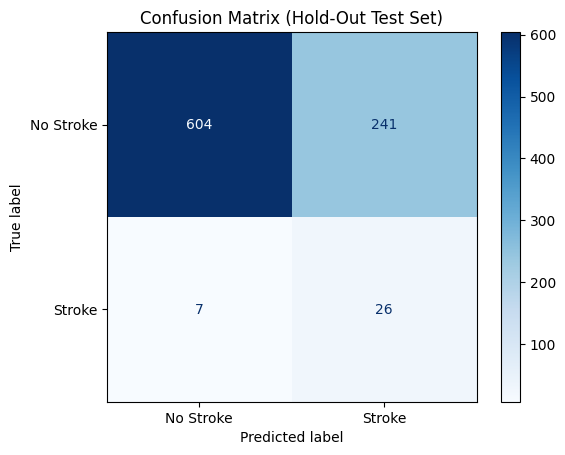

In [62]:
# STEP 4: Train on Full Training Set and Predict on Test Set
pipeline_with_smote.fit(X_train, y_train)
y_pred_test = pipeline_with_smote.predict(X_test)

# STEP 5: Evaluate on the Test Set
print("\nEvaluation on the Hold-Out Test Set:")
print(classification_report(y_test, y_pred_test, target_names=["No Stroke", "Stroke"]))

# STEP 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Hold-Out Test Set)")
plt.show()


- The model shows **high precision (0.99)** for the **No Stroke** class, meaning it very rarely misclassifies patients without a stroke as having one.
- However, the **Stroke class precision is low (0.10)**, indicating many false positives among predicted strokes.
- The **recall is relatively high for both classes** (0.71 for No Stroke, 0.79 for Stroke), meaning the model correctly identifies a majority of true cases in both groups.
- The overall **accuracy is 72%**, reflecting decent general performance but influenced by class imbalance.
- The **F1-score for Stroke is low (0.17)**, highlighting difficulty in balancing precision and recall for the minority stroke class.
- The **macro average metrics** treat both classes equally and show moderate recall but low precision and F1 overall, affected by the stroke class performance.
- The **weighted averages**, which account for class support, reflect the strong performance on the majority class (No Stroke).

---

### Summary:

While the model effectively identifies patients without stroke (high precision), it struggles to precisely predict stroke cases, likely due to class imbalance and the low number of stroke instances. Nonetheless, the model captures a majority of actual stroke cases (high recall), which is important for clinical risk detection but comes at the cost of many false positives.

Further tuning or use of additional techniques (e.g., class balancing, threshold adjustment) could improve stroke class precision and the overall F1-score.

## ROC AUC Curve

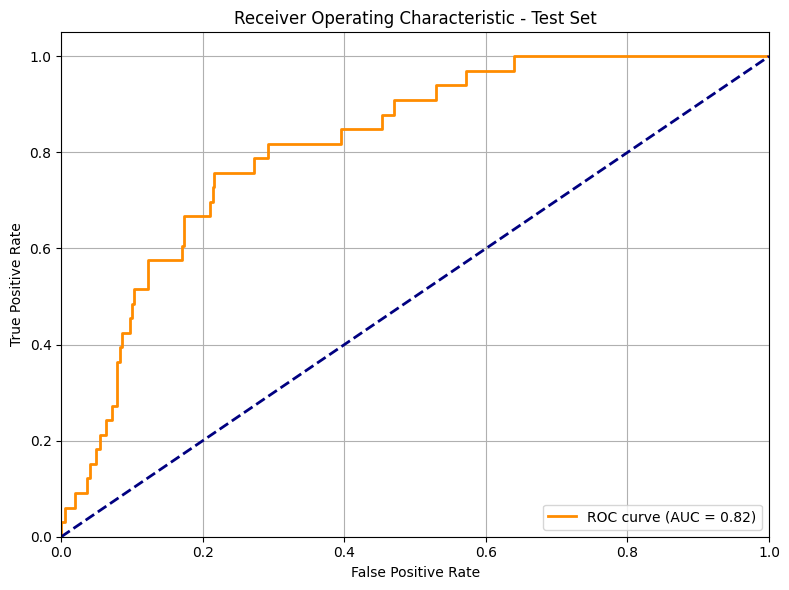

In [63]:
# Get predicted probabilities for the positive class
y_proba_test = pipeline_with_smote.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Receiver Operating Characteristic (ROC) Curve

The **ROC Curve** is a graphical representation of a classifier’s performance across various discrimination thresholds. It illustrates the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)**.

### Definitions

- **True Positive Rate (TPR)**, also known as **Recall** or **Sensitivity**:
  
  $$
  \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  $$

- **False Positive Rate (FPR)**:

  $$
  \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
  $$

Where:
- **TP** = True Positives  
- **FP** = False Positives  
- **FN** = False Negatives  
- **TN** = True Negatives

### ROC Curve

- The **x-axis** plots the False Positive Rate (FPR).
- The **y-axis** plots the True Positive Rate (TPR).
- Each point on the ROC curve corresponds to a different classification threshold.

### Area Under the Curve (AUC)

The **AUC** quantifies the overall ability of the model to discriminate between the positive and negative classes. It ranges from 0 to 1.

- **AUC = 1.0**: Perfect classifier  
- **AUC = 0.5**: No discrimination (equivalent to random guessing)  
- **AUC < 0.5**: Worse than random guessing


- Overall this is a good model due to the AUC equalling to 82%, thus the model is reliable at differentiating which patients are at risk for a stroke.
- When it comes to its actual usability, that would depend on predetermined clinical thresholds.

In [64]:
# Step 1: Construct input for a sample individual
sample_person = pd.DataFrame([{
    'gender': 'Male',                     # Most frequent or your choice
    'age': 64,
    'hypertension': 1,                   # Default: no hypertension
    'heart_disease': 1,                  # Default: no heart disease
    'ever_married': 'No',
    'work_type': 'Private',              # Most common category
    'Residence_type': 'Urban',           # Most common
    'avg_glucose_level': 114.0,           # A normal value
    'bmi': 31.2,                         # Based on 200 lbs and 5'4"
    'smoking_status': 'smokes'
}])

# Step 2: Predict using your pipeline
predicted_class = pipeline_with_smote.predict(sample_person)[0]
predicted_proba = pipeline_with_smote.predict_proba(sample_person)[0][1]

# Step 3: Show result
print(f"Predicted Stroke Risk Class: {'Stroke' if predicted_class == 1 else 'No Stroke'}")
print(f"Predicted Probability of Stroke: {predicted_proba:.4f}")

Predicted Stroke Risk Class: Stroke
Predicted Probability of Stroke: 0.8496
